In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from qec_util.performance import plots, confidence_interval_binomial
from qec_util.samplers import read_failures_from_file
from surface_sim.models import SI1000NoiseModel
from lomatching import MoMatching

In [2]:
import matplotlib
import matplotlib.ticker as ticker

matplotlib.rcParams.update(
    {
        "font.size": 11,
        "font.family": "cmr10",
        "font.weight": "normal",
        'axes.unicode_minus': False,
        "axes.formatter.use_mathtext": True,
        "text.usetex": True,
        "axes.formatter.limits": (0,0),
    }
)

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

int_to_alph = {i: s for i, s in enumerate("abcdefghijklmnopqrstuvwxyz")}

In [3]:
# INPUTS
EXPERIMENTS = ["I", "H", "S", "CNOT-no-alternating", "CNOT-alternating"]
DISTANCES = [3, 5, 7]
PROBS = [
    0.0002,
    0.0005,
    0.001,
    0.00116591,
    0.00135936,
    0.00158489,
    0.00184785,
    0.002,
    0.00215443,
    0.00251189,
    0.00292864,
    0.00341455,
    0.00398107,
    0.00464159,
    0.005,
    0.0054117,
    0.00630957,
    0.00735642,
    0.00857696,
    0.01,
]
NOISE_MODEL = SI1000NoiseModel
BASES = ["Z", "X"]
FRAMES = ["pre-gate"]
NUM_QEC_PER_GATE = 1
DECODER = MoMatching

# DATA STORAGE
NAME_FORMAT = "{exp_name}_{noise_model}_{decoder}_d{distance}_b{basis}_f{frame}_s0_ncycle-{ncycle}_p{prob:0.10f}.txt"
DATA_DIR = pathlib.Path("data")
PLOTS_DIR = pathlib.Path("plots")

In [4]:
if not PLOTS_DIR.exists():
    PLOTS_DIR.mkdir(parents=True)

In [5]:
NUM_FAILURES = np.zeros((len(EXPERIMENTS), len(BASES), len(FRAMES), len(DISTANCES), len(PROBS)))
NUM_SAMPLES = np.zeros((len(EXPERIMENTS), len(BASES), len(FRAMES), len(DISTANCES), len(PROBS)))

for i, experiment_name in enumerate(EXPERIMENTS):
    for j, basis in enumerate(BASES):
        for k, frame in enumerate(FRAMES):
            for l, distance in enumerate(DISTANCES):
                for m, prob in enumerate(PROBS):
                    file_name = NAME_FORMAT.format(
                       exp_name=experiment_name,
                       noise_model=NOISE_MODEL.__name__,
                       distance=distance,
                       basis=basis,
                       frame=frame,
                       prob=prob,                       
                       decoder=DECODER.__name__,       
                       ncycle=NUM_QEC_PER_GATE,
                    )

                    if not (DATA_DIR / file_name).exists():
                        print("MISSING --", DATA_DIR / file_name)
                        continue

                    try:
                        num_failures, num_samples, extra = read_failures_from_file(DATA_DIR / file_name)
                        NUM_FAILURES[i,j,k,l,m] = num_failures
                        NUM_SAMPLES[i,j,k,l,m] = num_samples
                    except:
                        print("BAD --", DATA_DIR / file_name)

LOG_PROB = NUM_FAILURES / NUM_SAMPLES
LOG_PROB_LOWER, LOG_PROB_UPPER = confidence_interval_binomial(NUM_FAILURES, NUM_SAMPLES)

In [6]:
print((NUM_SAMPLES != 0).sum())
assert (NUM_SAMPLES != 0).all()

600


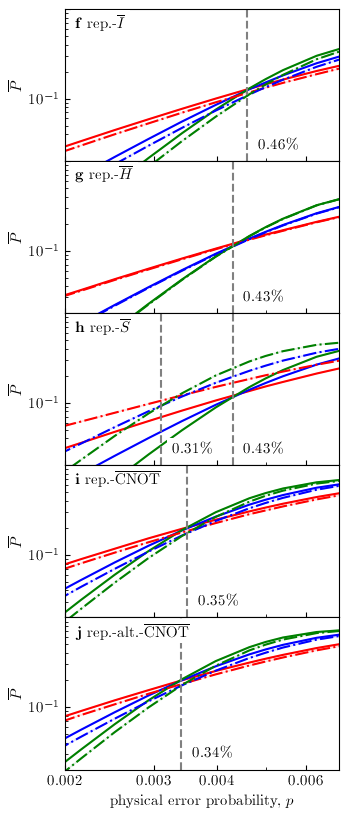

In [7]:
fig, axes = plt.subplots(nrows=len(EXPERIMENTS), figsize=cm2inch(8.6, 20.5))
for i, experiment_name in enumerate(EXPERIMENTS):
    ax = axes[i]

    color_distances_frame = [["red", "blue", "green", "purple"]]
    for k, frame in enumerate(FRAMES):
        color_distances = color_distances_frame[k]
        marker_basis = ["s", "*"]
        for j, basis in enumerate(BASES):
            for l, distance in enumerate(DISTANCES):
                plots.plot_line_threshold(ax, PROBS, LOG_PROB[i,j,k,l], LOG_PROB_LOWER[i,j,k,l], LOG_PROB_UPPER[i,j,k,l], 
                                          linestyle="-" if basis == "Z" else "-.",
                                          color=color_distances[l], marker="none")
        
    if experiment_name == "CNOT-alternating":
        name = "rep.-alt.-$\\overline{\\mathrm{CNOT}}$"
    elif experiment_name == "CNOT-no-alternating":
        name = "rep.-$\\overline{\\mathrm{CNOT}}$"
    else:
        name = f"rep.-$\\overline{{{experiment_name}}}$"

    xticks = [2e-3, 3e-3, 4e-3, 6e-3]
    xmin, xmax = xticks[0], 7e-3

    if "CNOT" not in experiment_name:
        ymin, ymax = 2e-2, 0.99999999
    else:
        ymin, ymax = 2e-2, 0.99999999
    ax.set_xlim(xmin, xmax)
    ax.set_yticks([1e-2, 1e-1])
    ax.set_ylim(ymin, ymax)
    ax.text(xmin*1.05, ymax/1.6, f"\\textbf{{{int_to_alph[i+5]}}} {name}", 
           bbox=dict(facecolor='white', edgecolor='none', pad=3.0))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel("$\\overline{P}$")
    ax.tick_params(direction="in", which="major")
    ax.tick_params(direction="in", which="minor")
    
    ax.set_xticks(xticks)
    if i != len(EXPERIMENTS) - 1:
        ax.set_xlabel("")
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("physical error probability, $p$")
        ax.set_xticklabels(map(str, xticks))

    if "I" in experiment_name:
        thr = 4.6/1000
        ax.axvline(x=thr, color="gray", linestyle="--")
        ax.text(1.05*thr, ymin*1.4, f"{thr*100:0.2f}\\%",
           bbox=dict(facecolor='white', edgecolor='none', pad=3.0))
    elif "H" in experiment_name:
        thr = 4.3/1000
        ax.axvline(x=thr, color="gray", linestyle="--")
        ax.text(1.05*thr, ymin*1.4, f"{thr*100:0.2f}\\%", 
           bbox=dict(facecolor='white', edgecolor='none', pad=3.0))
    elif "S" in experiment_name:
        thr = 3.1/1000
        ax.axvline(x=thr, color="gray", linestyle="--")
        ax.text(1.05*thr, ymin*1.4, f"{thr*100:0.2f}\\%", 
           bbox=dict(facecolor='white', edgecolor='none', pad=3.0))
    
        thr = 4.3/1000
        ax.axvline(x=thr, color="gray", linestyle="--")
        ax.text(1.05*thr, ymin*1.4, f"{thr*100:0.2f}\\%", 
           bbox=dict(facecolor='white', edgecolor='none', pad=3.0))
    elif "no-" in experiment_name:
        thr = 3.5/1000
        ax.axvline(x=thr, color="gray", linestyle="--")
        ax.text(1.05*thr, ymin*1.4, f"{thr*100:0.2f}\\%", 
           bbox=dict(facecolor='white', edgecolor='none', pad=3.0))
    else:
        thr = 3.4/1000
        ax.axvline(x=thr, color="gray", linestyle="--")
        ax.text(1.05*thr, ymin*1.4, f"{thr*100:0.2f}\\%", 
           bbox=dict(facecolor='white', edgecolor='none', pad=3.0))
    
fig.tight_layout(pad=0.30)
plt.subplots_adjust(hspace=.0)
fig.savefig(PLOTS_DIR / f"threshold_plot_repeated_exp_circ-level-noise_ncycles-{NUM_QEC_PER_GATE}_SI1000.pdf", format="pdf")
plt.show()

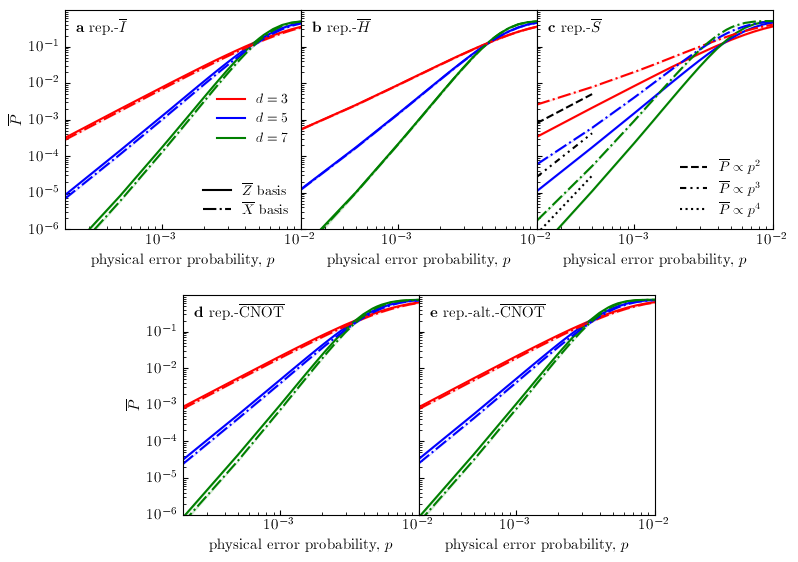

In [8]:
fig = plt.figure(figsize=cm2inch(20, 14))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2, fig=fig)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2, fig=fig)

axes = [ax1, ax2, ax3, ax4, ax5]

for i, experiment_name in enumerate(EXPERIMENTS):
    ax = axes[i]

    color_distances_frame = [["red", "blue", "green", "purple"],]  
    for k, frame in enumerate(FRAMES):
        color_distances = color_distances_frame[k]
        marker_basis = ["s", "*"]
        for j, basis in enumerate(BASES):
            for l, distance in enumerate(DISTANCES):
                plots.plot_line_threshold(ax, PROBS, LOG_PROB[i,j,k,l], LOG_PROB_LOWER[i,j,k,l], LOG_PROB_UPPER[i,j,k,l], 
                                          linestyle="-" if basis == "Z" else "-.",
                                          color=color_distances[l], marker="none")
        
    if experiment_name == "CNOT-alternating":
        name = "rep.-alt.-$\\overline{\\mathrm{CNOT}}$"
    elif experiment_name == "CNOT-no-alternating":
        name = "rep.-$\\overline{\\mathrm{CNOT}}$"
    else:
        name = f"rep.-$\\overline{{{experiment_name}}}$"

    xmin, xmax = 2e-4, 7e-3

    if "CNOT" not in experiment_name:
        ymin, ymax = 1e-6, 0.99999999
    else:
        ymin, ymax = 1e-6, 0.99999999
    ax.set_xlim(xmin, xmax)
    ax.set_yticks([1e-2, 1e-1])
    ax.set_ylim(ymin, ymax)
    ax.text(xmin*1.2, ymax/4, f"\\textbf{{{int_to_alph[i]}}} {name}", 
           bbox=dict(facecolor='white', edgecolor='none', pad=2.0))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.tick_params(direction="in", which="major")
    ax.tick_params(direction="in", which="minor")
    
    xticks = [1e-3, 1e-2]
    ax.set_xticks(xticks)
    if i not in [0, 3]:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("$\\overline{P}$")
        
    ax.set_xlabel("physical error probability, $p$")
    ax.set_xticklabels([f"$10^{{{int(np.log10(x))}}}$" for x in xticks])

    if i == 2:
        labels = ["$\\overline{P} \\propto p^2$", "$\\overline{P} \\propto p^3$", "$\\overline{P} \\propto p^4$"]
        PROBS_ = np.array(PROBS)
        PROBS_ = PROBS_[PROBS_ <1e-3]
        ax.plot(PROBS_, PROBS_**2 * 2e4, "--", color="black", label=labels[0])
        ax.plot(PROBS_, PROBS_**3 * 3.4e6, linestyle=(0, (3, 2, 1, 2, 1, 2)), color="black", label=labels[1])
        ax.plot(PROBS_, PROBS_**4 * 4.7e8, ":", color="black", label=labels[2])
        ax.legend(loc="lower right", fontsize=10, frameon=False)

ax = axes[0]
lines = []
for l, distance in enumerate(DISTANCES):
    line, = ax.plot([], [], color=color_distances[l], linestyle="-", label=f"$d = {distance}$")
    lines.append(line)
legend = ax.legend(handles=lines, loc="center right", fontsize=10, frameon=False)
ax.add_artist(legend)

ax = axes[0]
line1, = ax.plot([], [], color="black", linestyle="-", label="$\\overline{Z}$ basis")
line2, = ax.plot([], [], color="black", linestyle="-.", label="$\\overline{X}$ basis")
ax.legend(handles=[line1, line2], loc="lower right", fontsize=10, frameon=False)

fig.tight_layout(pad=0.30)
plt.subplots_adjust(wspace=.0, hspace=0.3)
fig.savefig(PLOTS_DIR / f"threshold_plot_repeated_exp_circ-level-noise_ncycles-{NUM_QEC_PER_GATE}_scaling_SI1000.pdf", format="pdf")
plt.show()

fig.tight_layout()